In [1]:
%matplotlib inline
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

import sys
import numpy as np
import psutil
from scipy.ndimage.filters import gaussian_filter
from ipyparallel import Client

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d,plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
import caiman.source_extraction.cnmf as cnmf
from caiman.components_evaluation import evaluate_components

import matplotlib.pyplot as plt
import bokeh.plotting as bpl
bpl.output_notebook()

1


Loading BokehJS ...

In [2]:
fname='/Users/elyall/Dropbox/Data/2479_150721_500_small.sbx'
#fname='/Users/elyall/Dropbox/Data/2479_150721_500.sbx'

#fname='/home/elyall/Dropbox/Data/2479_150721_500_small.sbx'
#fname='/home/elyall/Dropbox/Data/2479_150721_500.sbx'

sbx
(499, 40, 60)


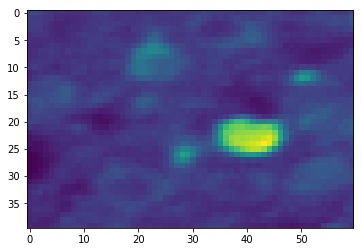

In [3]:
# TEST LOADING
Data = cm.base.movies.load(fname)
print(Data.shape)
plt.imshow(Data.mean(0))

# Start Cluster

In [4]:
# START CLUSTER
n_processes = None # None to use all processes
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=n_processes, single_thread=False)

Client did not exist, creating one
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......Using 8 processes


# MOTION CORRECTION

Rigid Motion Correction
63705


/Users/elyall/Documents/AdesnikLab/Code/CaImAn/caiman/base/movies.py:241: UserWarning: Casting the array to float 32
  warnings.warn('Casting the array to float 32')
/Users/elyall/Documents/AdesnikLab/Code/CaImAn/caiman/base/movies.py:327: UserWarning: Casting the array to float 32
  warnings.warn('Casting the array to float 32')


Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Adding to movie 63705
0
saving!
5.282209157943726
0.0732869


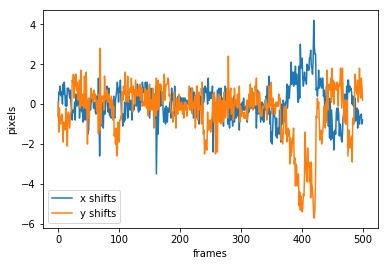

In [5]:
# set parameters
params_movie = {'fname': fname,
                'niter_rig': 1,
                'max_shifts': (6, 6),  # maximum allow rigid shift
                'splits_rig': 56,  # for parallelization split the movies in  num_splits chuncks across time
                # if none all the splits are processed and the movie is saved
                'num_splits_to_process_rig': None,
                # intervals at which patches are laid out for motion correction
                'strides': (48, 48),
                # overlap between pathes (size of patch strides+overlaps)
                'overlaps': (24, 24),
                'splits_els': 56,  # for parallelization split the movies in  num_splits chuncks across time
                # if none all the splits are processed and the movie is saved
                'num_splits_to_process_els': [28, None],
                'upsample_factor_grid': 4,  # upsample factor to avoid smearing when merging patches
                # maximum deviation allowed for patch with respect to rigid
                # shift
                'max_deviation_rigid': 3,
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 0.8,  # merging threshold, max correlation allowed
                'rf': 15,  # half-size of the patches in pixels. rf=25, patches are 50x50
                'stride_cnmf': 6,  # amounpl.it of overlap between the patches in pixels
                'K': 4,  # number of components per patch
                # if dendritic. In this case you need to set init_method to
                # sparse_nmf
                'is_dendrites': False,
                'init_method': 'greedy_roi',
                'gSig': [4, 4],  # expected half size of neurons
                'alpha_snmf': None,  # this controls sparsity
                'final_frate': 15.46
                }

#%% parameters from dictionary
fname = params_movie['fname']
niter_rig = params_movie['niter_rig']
# maximum allow rigid shift
max_shifts = params_movie['max_shifts']  
# for parallelization split the movies in  num_splits chuncks across time
splits_rig = params_movie['splits_rig']  
# if none all the splits are processed and the movie is saved
num_splits_to_process_rig = params_movie['num_splits_to_process_rig']
# intervals at which patches are laid out for motion correction
strides = params_movie['strides']
# overlap between pathes (size of patch strides+overlaps)
overlaps = params_movie['overlaps']
# for parallelization split the movies in  num_splits chuncks across time
splits_els = params_movie['splits_els'] 
# if none all the splits are processed and the movie is saved
num_splits_to_process_els = params_movie['num_splits_to_process_els']
# upsample factor to avoid smearing when merging patches
upsample_factor_grid = params_movie['upsample_factor_grid'] 
# maximum deviation allowed for patch with respect to rigid
# shift
max_deviation_rigid = params_movie['max_deviation_rigid']

# perform rigid motion correction (movie must be mostly positive for this to work)
min_mov = cm.load(fname, subindices=range(400)).min()
mc = cm.motion_correction.MotionCorrect(fname, min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig, splits_rig=splits_rig, 
                   num_splits_to_process_rig=num_splits_to_process_rig, 
                   strides= strides, overlaps= overlaps, splits_els=splits_els,
                   num_splits_to_process_els=num_splits_to_process_els, 
                   upsample_factor_grid=upsample_factor_grid, max_deviation_rigid=max_deviation_rigid, 
                   shifts_opencv=True, nonneg_movie=True)

mc.motion_correct_rigid(save_movie=False)

# display correction
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

In [6]:
# SAVE DATA TO MEMMAP FILE
fname = cm.save_memmap([fname], base_name='Yr', xy_shifts=mc.shifts_rig)
print(fname)

/Users/elyall/Dropbox/Data/2479_150721_500_small.sbx
sbx
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
/Users/elyall/Dropbox/Data/Yr_d1_40_d2_60_d3_1_order_F_frames_499_.mmap


/Users/elyall/Documents/AdesnikLab/Code/CaImAn/caiman/base/movies.py:327: UserWarning: Casting the array to float 32
  warnings.warn('Casting the array to float 32')


In [18]:
# LOAD MemMap FILE
Yr, dims, T = cm.load_memmap(fname)
print(type(Yr),Yr.shape,dims,T)

<class 'numpy.core.memmap.memmap'> (2400, 499) (40, 60) 499


In [39]:
# LOAD Direct FILE
fn='/Users/elyall/Dropbox/Data/2479_150721_500_small.sbx'
Yr = cm.base.movies.load(fn)
Yr = Yr.apply_shifts(mc.shifts_rig)
Yr = Yr.transpose([2,1,0]).reshape([40*60,499])
print(type(Yr),Yr.shape)

sbx
linear interpolation
Frame 100
Frame 200
Frame 300
Frame 400
<class 'caiman.base.movies.movie'> (2400, 499)


/Users/elyall/Documents/AdesnikLab/Code/CaImAn/caiman/base/movies.py:327: UserWarning: Casting the array to float 32
  warnings.warn('Casting the array to float 32')


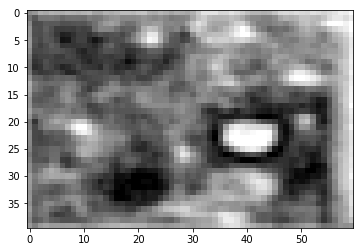

In [40]:
# Compute local correlations to get a sense of the data
Y = np.reshape(Yr, dims + (T,), order='F')
Cn = cm.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape) == 3 else Cn, cmap='gray',
           vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))
plt.show()

# CNMF

In [9]:
# SET PATCHES TO SPLIT
K = 4  # number of neurons expected per patch
# single patch
rf = None
stride = None
# full field of view
rf = (25, 25)  # half-size of the patches in pixels. rf=25, patches are 50x50
stride = (10, 10)  # amount of overlap between the patches in pixels

# SET PARAMETERS
gSig = [10, 10]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system
init_method = 'greedy_roi'
method_deconvolution='oasis' # 'oasis' is fastest
alpha_snmf = None  # 10e2  # this controls sparsity
save_results = False

# INIT
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=p, dview=c[:], Ain=None, rf=rf, stride=stride, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, method_deconvolution=method_deconvolution)

# FIT
images = np.reshape(Yr.T, [T] + list(dims), order='F')
cnm = cnm.fit(images)

(499, 40, 60)
using 8 processes
using 4000 pixels per process
using 20000 block_size
(40, 51)
(40, 50)
You may think that it went well but reality is harsh
0.8878669738769531
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background
using 8 processes
using 4000 pixels per process
using 20000 block_size
merging
[1 2 6]
[0 3 5]
done merging
********** No neurons merged! ***************
done merging
update temporal
Generating residuals
parallel dot product block size: 20000
Start product
Transposing
2399
entering the deconvolution 


/Users/elyall/anaconda/envs/CaImAn/lib/python3.5/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


2 out of total 4 temporal components updated
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
2 out of total 4 temporal components updated
3 out of total 4 temporal components updated
4 out of total 4 temporal components updated
stopping: overall temporal component not changing significantly


In [10]:
# view components
if type(cnm.A) == np.core.memmap:
    p1=nb_plot_contour(images.mean(0),cnm.A,dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
else:
    p1=nb_plot_contour(images.mean(0),cnm.A.todense(),dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

/Users/elyall/Documents/AdesnikLab/Code/CaImAn/caiman/utils/visualization.py:897: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


In [11]:
# STOP CLUSTER
print("Stopping  cluster to avoid unnencessary use of memory....")
sys.stdout.flush()  
cm.stop_server()

Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
